## Project Link:

https://www.kaggle.com/rikdifos/credit-card-approval-prediction?select=credit_record.csv

In [223]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost
from xgboost import XGBClassifier
import lightgbm
from lightgbm import LGBMClassifier

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

import imblearn
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
sns.set_palette(['#06B1F0', '#FC4B60'])

random_seed = 1001

## FLOW:

- On the dataset for which I provided the link above, I aim to build an accurate model which will the approval or rejection decision based on its prediction about whether the applicant will default or not. In a real-world case, using the discriminative power of this model by ordering probability outputs, defining risk-based homogenous clusters and applying different cut-off levels for each of them would be a more appropriate approach. However, here, I chose to focus on the modelling part.
- Data Examination
- Target Definition
- Feature Engineering
- Encoding
- Transformation
- Resampling
- Advance ML Algorithms
- Hyperparameter Tuning

In [25]:
app = pd.read_csv('application_record.csv')
cr = pd.read_csv('credit_record.csv')

### Data Analysis:

1. application_record: Contains some attributes about the applicant.
2. credit_record: Contains monthly information of past credits. There are multiple rows for each applicant in this dataset.

TARGET: The target is not readily provided in the data. I will use credit_record data to construct a default_f which indicates whether an applicant has defaulted before or not. The customers who are in credit_record data and do not have only X (no loan for the month) values in STATUS column are either flagged as 0 or 1, the remaining data left null. Whilst assigning good as default_f, I put an additional condition to customer observing 30+ delinquency condition: Customer should observe at least 12 months to be eligible for good flag.

In [31]:
def target(df):
    status_bad =['2','3','4','5']
    new_df = pd.DataFrame(columns=['ID','DEFAULT_F'])
    data = df[df.STATUS!='X'].reset_index(drop=True)
    for val in data.ID.unique():
        loc = len(new_df)
        filtered = data[data.ID==val]
        filtered.reset_index(drop=True, inplace=True)
        
        if len([i for i in status_bad if i in list(filtered['STATUS'])])>0:
            row =[val,1]
            new_df.loc[loc] = row
        elif len(filtered)>=12:
            row=[val,0]
            new_df.loc[loc] = row
        else:
            continue
            
        new_df.reset_index(drop=True,inplace=True)
        new_df = new_df.astype(np.int64)
    return new_df

In [32]:
cr_new = target(cr)
cr_new.to_csv('credit_records_updated.csv')

In [34]:
final = pd.merge(cr_new,app,how='inner',on='ID')
final.to_pickle('final_data.pkl')

### Null Control:

In [37]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20108 entries, 0 to 20107
Data columns (total 19 columns):
ID                     20108 non-null int64
DEFAULT_F              20108 non-null int64
CODE_GENDER            20108 non-null object
FLAG_OWN_CAR           20108 non-null object
FLAG_OWN_REALTY        20108 non-null object
CNT_CHILDREN           20108 non-null int64
AMT_INCOME_TOTAL       20108 non-null float64
NAME_INCOME_TYPE       20108 non-null object
NAME_EDUCATION_TYPE    20108 non-null object
NAME_FAMILY_STATUS     20108 non-null object
NAME_HOUSING_TYPE      20108 non-null object
DAYS_BIRTH             20108 non-null int64
DAYS_EMPLOYED          20108 non-null int64
FLAG_MOBIL             20108 non-null int64
FLAG_WORK_PHONE        20108 non-null int64
FLAG_PHONE             20108 non-null int64
FLAG_EMAIL             20108 non-null int64
OCCUPATION_TYPE        13881 non-null object
CNT_FAM_MEMBERS        20108 non-null float64
dtypes: float64(2), int64(9), object(8)
mem

In [50]:
final = final[~final.OCCUPATION_TYPE.isna()].reset_index(drop=True)
final.to_pickle('final_data.pkl')

### Feature Engineering:

In [84]:
final.describe()

,ID,DEFAULT_F,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,Age,Work_months
count,1.388100e+04,13881.000000,13881.000000,1.388100e+04,13881.0,13881.000000,13881.000000,13881.000000,13881.000000,13881.000000,13881.000000
mean,5.079240e+06,0.030401,0.490022,1.963589e+05,1.0,0.275989,0.296088,0.100497,2.300915,41.098840,91.625500
std,4.221709e+04,0.171695,0.707864,1.041551e+05,0.0,0.447027,0.456547,0.300672,0.937302,9.424317,79.852792
min,5.008806e+06,0.000000,0.000000,2.700000e+04,1.0,0.000000,0.000000,0.000000,1.000000,21.000000,1.433333
25%,5.042308e+06,0.000000,0.000000,1.350000e+05,1.0,0.000000,0.000000,0.000000,2.000000,33.000000,35.033333
50%,5.079207e+06,0.000000,0.000000,1.800000e+05,1.0,0.000000,0.000000,0.000000,2.000000,41.000000,70.533333
75%,5.115918e+06,0.000000,1.000000,2.295000e+05,1.0,1.000000,1.000000,0.000000,3.000000,48.000000,120.266667
max,5.150487e+06,1.000000,2.000000,1.575000e+06,1.0,1.000000,1.000000,1.000000,15.000000,67.000000,523.766667


In [91]:
final.columns

Index(['ID', 'DEFAULT_F', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'Age', 'Work_months'],
      dtype='object')

##### Continuous Features:

In [56]:
#CNT_CHILDREN:

final['CNT_CHILDREN'] = np.where(final['CNT_CHILDREN']>=2,2,final['CNT_CHILDREN'])

In [78]:
#AMT_INCOME_TOTAL:

final['Age'] = round(-final.DAYS_BIRTH/365)
final = final.drop('DAYS_BIRTH',axis=1)

In [83]:
#DAYS_EMPLOYED:
final['DAYS_EMPLOYED'] = np.where(final['DAYS_EMPLOYED']>=0,0,final['DAYS_EMPLOYED'])
final['Work_months'] = -final.DAYS_EMPLOYED/30
final = final.drop('DAYS_EMPLOYED',axis=1)

In [89]:
#CNT_FAM_MEMBERS:

final = final.drop('CNT_FAM_MEMBERS',axis=1)

In [90]:
final.to_pickle('final_data.pkl')

##### Categorical Features:

In [51]:
final = pd.read_pickle('final_data.pkl')

In [52]:
#FLAG_MOBIL: All 1 values.
final =final.drop('FLAG_MOBIL',axis=1)

In [53]:
#FLAG_WORK_PHONE: Nothing to do here.
final.FLAG_WORK_PHONE.describe()

count    13881.000000
mean         0.275989
std          0.447027
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: FLAG_WORK_PHONE, dtype: float64

In [54]:
#FLAG_PHONE: Nothing to do here.
final.FLAG_PHONE.describe()

count    13881.000000
mean         0.296088
std          0.456547
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: FLAG_PHONE, dtype: float64

In [55]:
#FLAG_EMAIL: Nothing to do here
final.FLAG_EMAIL.describe()

count    13881.000000
mean         0.100497
std          0.300672
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: FLAG_EMAIL, dtype: float64

In [56]:
#CODE_GENDER
final.CODE_GENDER.replace(['M','F'],[0,1],inplace=True)

In [57]:
#FLAG_OWN_CAR
final.FLAG_OWN_CAR.replace(['N','Y'],[0,1],inplace=True)

In [58]:
#FLAG_OWN_REALTY
final.FLAG_OWN_REALTY.replace(['N','Y'],[0,1],inplace=True)

### Encoding Definition:

In [59]:
def convert(df,encode_list,ohe_list):
    data = df.copy()
    le = preprocessing.LabelEncoder()
    
    final_map = pd.DataFrame(columns=['Attribute','Original', 'Label'])
    
    for encode in encode_list:
        
        data[encode] = le.fit_transform(data[encode])
        le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        map_df = pd.DataFrame({'Attribute':encode,'Original':list(le_name_mapping.keys()),'Label':list(le_name_mapping.values())})
            
            
        #encode,le_name_mapping.items(), columns=['Attribute','Original', 'Label'])
        final_map = final_map.append(map_df)
        
    final_map.reset_index(drop=True,inplace=True)
    final_map.to_pickle('labeling_stored.pkl')
    
    for onehat in ohe_list:
        ohe = pd.get_dummies(data[onehat],drop_first=True)
        data = data.drop(onehat,axis=1)
        data = data.join(ohe)
        
    
    return data,final_map

In [60]:
#NAME_INCOME_TYPE
final.NAME_INCOME_TYPE.unique()
encode_list = []
ohe_list = ['NAME_INCOME_TYPE']
final,income_map = convert(final,encode_list,ohe_list)

In [61]:
#NAME_EDUCATION_TYPE: 
final.NAME_EDUCATION_TYPE.unique()
final.NAME_EDUCATION_TYPE = final.NAME_EDUCATION_TYPE.map({'Lower secondary':0,
                        'Secondary / secondary special':1,
                        'Incomplete higher':2,
                        'Higher education':3,
                        'Academic degree':4})

In [62]:
#NAME_FAMILY_STATUS:
final.NAME_FAMILY_STATUS.unique()
encode_list = []
ohe_list = ['NAME_FAMILY_STATUS']
final,family_map = convert(final,encode_list,ohe_list)

In [63]:
#NAME_HOUSING_TYPE:
final.NAME_HOUSING_TYPE.unique()
encode_list = []
ohe_list = ['NAME_HOUSING_TYPE']
final,housing_map = convert(final,encode_list,ohe_list)

In [64]:
#OCCUPATION_TYPE:
final.OCCUPATION_TYPE.unique()
encode_list = []
ohe_list = ['OCCUPATION_TYPE']
final,occupation_map = convert(final,encode_list,ohe_list)

In [66]:
final.to_pickle('encoded_final_data.pkl')
encoded = final

### Normalization to continuous features:

Continuous features vary between large values and this might have severe effects if we would like to conduct regression models later.

In [67]:
cont_list = ['AMT_INCOME_TOTAL','Age','Work_months']
reg_data = encoded.copy()
for cont in cont_list:
    mean = reg_data[cont].mean()
    std = reg_data[cont].std()
    reg_data[cont] = (encoded[cont] - mean)/std

reg_data.to_pickle('regression_data.pkl')

# Modelling:

### Train - Test Split:

We should note that bad is the minority class in the dataset constituting 3% of the overall data. After splitting data into train and tes by 70% and 30% respectively, we might require resampling.

In [68]:
encoded = pd.read_pickle('encoded_final_data.pkl')

In [69]:
train,test = train_test_split(encoded,test_size=0.3)

### Resampling:

We have different resampling opportunities to implement such as over/down sampling, cluster based sampling, SMOTE or MSMOTE. For the sake of no information loss, I prefer not to go with down sampling. Below, different combinations of oversampling along with SMOTE resampling will be tried and tested by cross validation method and selected base algorithms on train and test data,respectively.

In [77]:
x_train1 = train.drop(['ID','DEFAULT_F'],axis=1)
y_train1 = train.DEFAULT_F

x_test = test.drop(['ID','DEFAULT_F'],axis=1)
y_test = test.DEFAULT_F

### Checking Simple Resampling Over & Under:

Normally, OverSampling is preferred not to cause information loss, but in our case, predicting minority group is more important and with the assumption that we would not lose valuable distinctive information by eliminating a portion of the majority data, I will try undersampling as well.

In [89]:
scorer=make_scorer(roc_auc_score, greater_is_better=True)
clf = DecisionTreeClassifier(random_state=random_seed)
rfc = RandomForestClassifier(n_estimators=50,random_state=random_seed)
ada = AdaBoostClassifier(n_estimators=50, random_state=random_seed)
gb = GradientBoostingClassifier(n_estimators=50, random_state=random_seed)
bgc = BaggingClassifier(base_estimator=clf, n_estimators=50, random_state=random_seed)
xgb = XGBClassifier(random_state= random_seed)

def try_base_model(model,x_train,y_train,x_test,y_test,name):
    model.fit(x_train,y_train)
    y_pred_proba = model.predict_proba(x_test)
    y_pred = model.predict(x_test)
    
    print (str(name).upper()+ """ Score Proba:""", roc_auc_score(y_test, y_pred_proba[:,1]))
    print (str(name).upper()+" Accuracy:",metrics.accuracy_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    print('tn, fp, fn, tp: ', tn, fp, fn, tp)
    print(" ")

When tried, ADA and GB boost algorithms perform inadequately with in terms of guessing defaulted customers even though they have high accuracy scores.

##### Over Sampling:

In [85]:
ros = RandomOverSampler(sampling_strategy = 0.5,random_state=random_seed)
x_over,y_over = ros.fit_resample(x_train1,y_train1)

In [99]:
try_base_model(clf,x_over,y_over,x_test,y_test,'Decision Tree ')
try_base_model(rfc,x_over,y_over,x_test,y_test,'Random Forest')
try_base_model(ada,x_over,y_over,x_test,y_test,'ADA')
try_base_model(gb,x_over,y_over,x_test,y_test,'GB')
try_base_model(bgc,x_over,y_over,x_test,y_test,'bgc')
try_base_model(xgb,x_over,y_over,x_test,y_test,'xgb')

DECISION TREE  Score Proba: 0.7224250455811213
DECISION TREE  Accuracy: 0.9531812725090036
tn, fp, fn, tp:  3916 135 60 54
 
RANDOM FOREST Score Proba: 0.7836076862113319
RANDOM FOREST Accuracy: 0.9623049219687875
tn, fp, fn, tp:  3957 94 63 51
 
ADA Score Proba: 0.6332711871013005
ADA Accuracy: 0.907563025210084
tn, fp, fn, tp:  3760 291 94 20
 
GB Score Proba: 0.6507998891328544
GB Accuracy: 0.9524609843937575
tn, fp, fn, tp:  3951 100 98 16
 
BGC Score Proba: 0.7871058478088581
BGC Accuracy: 0.9618247298919568
tn, fp, fn, tp:  3952 99 60 54
 
XGB Score Proba: 0.71651357472922
XGB Accuracy: 0.9611044417767107
tn, fp, fn, tp:  3948 103 59 55
 


In [124]:
rus = RandomUnderSampler(sampling_strategy = 0.25,random_state=random_seed)
x_under,y_under = rus.fit_resample(x_train1,y_train1)

In [125]:
try_base_model(clf,x_under,y_under,x_test,y_test,'Decision Tree ')
try_base_model(rfc,x_under,y_under,x_test,y_test,'Random Forest')
try_base_model(ada,x_under,y_under,x_test,y_test,'ADA')
try_base_model(gb,x_under,y_under,x_test,y_test,'GB')
try_base_model(bgc,x_under,y_under,x_test,y_test,'bgc')
try_base_model(xgb,x_under,y_under,x_test,y_test,'xgb')

DECISION TREE  Score Proba: 0.6805445482380353
DECISION TREE  Accuracy: 0.8446578631452581
tn, fp, fn, tp:  3462 589 58 56
 
RANDOM FOREST Score Proba: 0.7364718263196871
RANDOM FOREST Accuracy: 0.9601440576230492
tn, fp, fn, tp:  3949 102 64 50
 
ADA Score Proba: 0.6451493458405332
ADA Accuracy: 0.9637454981992797
tn, fp, fn, tp:  4009 42 109 5
 
GB Score Proba: 0.6573252434962993
GB Accuracy: 0.9704681872749099
tn, fp, fn, tp:  4036 15 108 6
 
BGC Score Proba: 0.7491219408679685
BGC Accuracy: 0.9495798319327731
tn, fp, fn, tp:  3905 146 64 50
 
XGB Score Proba: 0.7176374038032628
XGB Accuracy: 0.9258103241296518
tn, fp, fn, tp:  3804 247 62 52
 


### Resampling with SMOTE:

In [149]:
x_smote,y_smote = SMOTE(sampling_strategy=0.3).fit_sample(x_train1,y_train1)
x_smote = pd.DataFrame(x_smote, columns = x_train1.columns)

In [150]:
try_base_model(clf,x_smote,y_smote,x_test,y_test,'Decision Tree ')
try_base_model(rfc,x_smote,y_smote,x_test,y_test,'Random Forest')
try_base_model(ada,x_smote,y_smote,x_test,y_test,'ADA')
try_base_model(gb,x_smote,y_smote,x_test,y_test,'GB')
try_base_model(bgc,x_smote,y_smote,x_test,y_test,'bgc')
try_base_model(xgb,x_smote,y_smote,x_test,y_test,'xgb')

DECISION TREE  Score Proba: 0.7149685804241535
DECISION TREE  Accuracy: 0.9543817527010804
tn, fp, fn, tp:  3936 115 75 39
 
RANDOM FOREST Score Proba: 0.8044948832213834
RANDOM FOREST Accuracy: 0.9690276110444178
tn, fp, fn, tp:  3995 56 73 41
 
ADA Score Proba: 0.6138402040648401
ADA Accuracy: 0.9440576230492197
tn, fp, fn, tp:  3923 128 105 9
 
GB Score Proba: 0.6145623562733049
GB Accuracy: 0.9661464585834334
tn, fp, fn, tp:  4019 32 109 5
 
BGC Score Proba: 0.782636515999948
BGC Accuracy: 0.9680672268907563
tn, fp, fn, tp:  3995 56 77 37
 
XGB Score Proba: 0.691216593693565
XGB Accuracy: 0.9702280912364946
tn, fp, fn, tp:  4008 43 81 33
 


#### Selection = Simple Over Sampling with 0.5

In [161]:
clf = DecisionTreeClassifier(random_state=random_seed)
rfc = RandomForestClassifier(random_state=random_seed)
bgc = BaggingClassifier(base_estimator=clf, random_state=random_seed)
xgb = XGBClassifier(random_state= random_seed)

def try_base_model(model,x_train,y_train,x_test,y_test,name):
    model.fit(x_train,y_train)
    y_pred_proba = model.predict_proba(x_test)
    y_pred = model.predict(x_test)
    
    print (str(name).upper()+ """ Score Proba:""", roc_auc_score(y_test, y_pred_proba[:,1]))
    print (str(name).upper()+" Accuracy:",metrics.accuracy_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    print('tn, fp, fn, tp: ', tn, fp, fn, tp)
    print(" ")
    
def try_base_model_cv(model,x_train,y_train,name):
    cv_score = cross_val_score(model, x_train, y_train, cv=10, scoring=scorer)
    
    print(str(name).upper()+" CV Scores:\n ", cv_score)
    print("Mean AUC Score - "+str(name).upper()+" :", cv_score.mean())

In [154]:
ros = RandomOverSampler(sampling_strategy = 0.5,random_state=random_seed)
x_over,y_over = ros.fit_resample(x_train1,y_train1)

### Model Selection:

In [162]:
try_base_model_cv(clf,x_over,y_over,'Decision Tree')
try_base_model_cv(rfc,x_over,y_over,'Random Forest')
try_base_model_cv(bgc,x_over,y_over,'Bagging')
try_base_model_cv(xgb,x_over,y_over,'XGB')

DECISION TREE CV Scores:
  [0.97821467 0.97662062 0.97980871 0.97502657 0.97874601 0.97927397
 0.97927736 0.98140276 0.98031915 0.97873244]
Mean AUC Score - DECISION TREE : 0.9787422266384145
RANDOM FOREST CV Scores:
  [0.98299681 0.98299681 0.98671626 0.98618491 0.98459086 0.98565017
 0.98671626 0.98671626 0.98670213 0.9845835 ]
Mean AUC Score - RANDOM FOREST : 0.9853853970998973
BAGGING CV Scores:
  [0.98140276 0.98246546 0.98512221 0.98459086 0.98405951 0.98458747
 0.98459086 0.98565356 0.98617021 0.9845835 ]
Mean AUC Score - BAGGING : 0.9843226413172307
XGB CV Scores:
  [0.9776867  0.97662626 0.98459086 0.98299681 0.98193411 0.97980306
 0.98033554 0.98512108 0.98298098 0.98351967]
Mean AUC Score - XGB : 0.9815595080379802


In [158]:
try_base_model(clf,x_over,y_over,x_test,y_test,'Decision Tree ')
try_base_model(rfc,x_over,y_over,x_test,y_test,'Random Forest')
try_base_model(bgc,x_over,y_over,x_test,y_test,'bgc')
try_base_model(xgb,x_over,y_over,x_test,y_test,'xgb')

DECISION TREE  Score Proba: 0.7224250455811213
DECISION TREE  Accuracy: 0.9531812725090036
tn, fp, fn, tp:  3916 135 60 54
 
RANDOM FOREST Score Proba: 0.7836076862113319
RANDOM FOREST Accuracy: 0.9623049219687875
tn, fp, fn, tp:  3957 94 63 51
 
BGC Score Proba: 0.7871058478088581
BGC Accuracy: 0.9618247298919568
tn, fp, fn, tp:  3952 99 60 54
 
XGB Score Proba: 0.71651357472922
XGB Accuracy: 0.9611044417767107
tn, fp, fn, tp:  3948 103 59 55
 


### Feature Selection:

In [166]:
rfc.fit(x_over,y_over)
y_pred_proba = rfc.predict_proba(x_test)
y_pred = rfc.predict(x_test)

feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = x_over.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

z_feature_importances = (feature_importances['importance']-feature_importances['importance'].mean())/feature_importances['importance'].std()

In [181]:
feature_importances.reset_index(inplace=True)
selected = list(feature_importances['index'].iloc[0:11])

In [183]:
x_selected = x_over[selected]
y_selected = y_over
x_test = x_test[selected]
y_test = y_test

In [184]:
try_base_model_cv(clf,x_selected,y_selected,'Decision Tree')
try_base_model_cv(rfc,x_selected,y_selected,'Random Forest')
try_base_model_cv(bgc,x_selected,y_selected,'Bagging')
try_base_model_cv(xgb,x_selected,y_selected,'XGB')

try_base_model(clf,x_selected,y_selected,x_test,y_test,'Decision Tree ')
try_base_model(rfc,x_selected,y_selected,x_test,y_test,'Random Forest')
try_base_model(bgc,x_selected,y_selected,x_test,y_test,'bgc')
try_base_model(xgb,x_selected,y_selected,x_test,y_test,'xgb')

DECISION TREE CV Scores:
  [0.97555792 0.97449522 0.97874601 0.97715197 0.97874601 0.97289778
 0.97608927 0.98565356 0.97340426 0.98032818]
Mean AUC Score - DECISION TREE : 0.9773070173771036
RANDOM FOREST CV Scores:
  [0.98193411 0.98246546 0.98565356 0.98459086 0.98459086 0.98511882
 0.98512221 0.98671626 0.9856383  0.98351967]
Mean AUC Score - RANDOM FOREST : 0.984535011588784
BAGGING CV Scores:
  [0.98034006 0.98193411 0.98512221 0.98459086 0.98405951 0.98405612
 0.98352816 0.98671626 0.98297872 0.98192393]
Mean AUC Score - BAGGING : 0.9835249950830297
XGB CV Scores:
  [0.97343929 0.97662626 0.98246546 0.97714744 0.98034006 0.97927397
 0.98193298 0.98671626 0.98191715 0.97874147]
Mean AUC Score - XGB : 0.9798600354463511
DECISION TREE  Score Proba: 0.738705409537173
DECISION TREE  Accuracy: 0.9503001200480192
tn, fp, fn, tp:  3900 151 56 58
 
RANDOM FOREST Score Proba: 0.7900734927914701
RANDOM FOREST Accuracy: 0.9608643457382953
tn, fp, fn, tp:  3945 106 57 57
 
BGC Score Proba: 0

### RFE

In [205]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
kfold = StratifiedKFold(n_splits=10, random_state=1)
rfecv = RFECV(estimator=DecisionTreeClassifier(), step=1, cv=kfold,scoring=scorer)
rfecv = rfecv.fit(x_over, y_over)

In [215]:
df = pd.DataFrame(list(zip(x_over.columns, rfecv.ranking_, rfecv.estimator_.feature_importances_)), columns=['feature','ranking','importance'])

Optimal number of features : 34
Best features : Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_EDUCATION_TYPE', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'Age', 'Work_months', 'Pensioner',
       'State servant', 'Working', 'Married', 'Separated',
       'Single / not married', 'Widow', 'Municipal apartment',
       'Office apartment', 'With parents', 'Cleaning staff', 'Cooking staff',
       'Core staff', 'Drivers', 'High skill tech staff', 'IT staff',
       'Laborers', 'Low-skill Laborers', 'Managers', 'Medicine staff',
       'Private service staff', 'Sales staff', 'Waiters/barmen staff'],
      dtype='object')
Original features : Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_EDUCATION_TYPE', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'Age', 'Work_months', 'Pensioner',
       'State servant', 'Student', 'Working', 'Married', 'Separated',
    

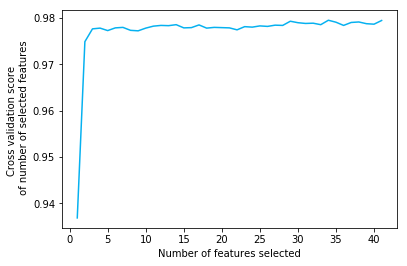

In [224]:
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', x_over.columns[rfecv.support_])
print('Original features :', x_over.columns)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score \n of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

### Hyperparameter Tuning:

In [225]:
n_estimators = [10,20,30,50,100]
max_depth  = [3,5,10,15,20,50]
min_samples_split = [50,100,150,200,250]
min_samples_leaf =[50,75,100,125,150]
bootstrap = [True, False]

In [226]:
grid_dict = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [229]:
def grid_search(grid_dict):

    rfc =  RandomForestClassifier(random_state=random_seed)

    model = GridSearchCV(estimator = rfc, param_grid=grid_dict, cv = 10, verbose= 5, n_jobs = -1,scoring=scorer)
    model.fit(x_selected,y_selected)

    pred = model.best_estimator_.predict(x_test)
    pred_prob = model.best_estimator_.predict_proba(x_test)
    print(confusion_matrix(y_test,pred))
    print(metrics.accuracy_score(y_test,pred))
    print(metrics.roc_auc_score(y_test,pred))
    print('with prob: '+ str(metrics.roc_auc_score(y_test,pred_prob[:,1])))
    print(model.best_estimator_)
    print('scorer_score_train '+str(scorer(model.best_estimator_,x_selected,y_selected)))

In [230]:
grid_search(grid_dict)

Fitting 10 folds for each of 1500 candidates, totalling 15000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2170 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 3034 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 3520 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | ela

[[3943  108]
 [  77   37]]
0.9555822328931572
0.648950659789439
with prob: 0.7675969113106142
RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_leaf=50,
                       min_samples_split=50, n_estimators=10,
                       random_state=1001)
scorer_score_train 0.8418367346938775
